In [1]:
#!git clone https://github.com/darioka/impactdeal-2022.git
#%cd impactdeal-2022
#!pip install -r requirements.txt
#!pip install .

# Hyperparameters

Looking at the documentations of many advanced machine learning models, we always find that a lot of options can be specified. These parameters are **not learned** by the model on the data and are called **hyperparameters**.
They are specific for every model and control how the model learns.


## Table of Contents

1. [Preprocessing](#Preprocessing)
2. [Hyperparameter tuning on validation data](#Hyperparameter-tuning-on-validation-data)
3. [Cross validation](#Cross-validation)
4. [Grid search](#Grid-search)
5. [Randomized search](#Randomized-search)
6. [Conclusions](#Conclusions)

## Preprocessing

We are now going prepare the dataset to train the `scikit-learn` [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html).

First, let's load it in the usual way. Then let's encode categorical variables. This time however we will leave missing values as they are: we want to exploit the model's native support for missing data.

In [2]:
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder


X, y = fetch_openml(data_id=1590, return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

numerical_cols = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_cols = ["workclass", "occupation", "sex", "marital-status", "race"]

oe = OrdinalEncoder()

cat_X_train = pd.DataFrame(
    oe.fit_transform(X_train[categorical_cols]),
    columns=categorical_cols, index=X_train.index
)
cat_X_test = pd.DataFrame(
    oe.transform(X_test[categorical_cols]),
    columns=categorical_cols, index=X_test.index
)

preprocessed_X_train = pd.concat([X_train[numerical_cols], cat_X_train], axis=1)
preprocessed_X_test = pd.concat([X_test[numerical_cols], cat_X_test], axis=1)

Now, how do we choose the right hyperparameters? There are no best values in general, everything depends on the problem at hand. Instead of choosing randomly, we could try to **find the hyperparameters that give the best performances**. The procedure could have the following steps:

1. Repeat $N$ times:
    1. choose a combinations of hyperameters,
    2. fit the model on the training dataset,
    3. evaluate the model on an independent dataset
2. Choose the model with the best performances.

Point (1.C) is fundamental: as we know, we cannot measure performances on the same dataset we used for training because they are overly optimistic. But we cannot use the test set either! If we exploit it to "learn" which are the best hyperparameters, we could use it for the final assessment on model performance. In other words, if we want it to be a valid test set, we should never use it to extract any kind of information, including hyperparameter search.

What should we do then? We have two possibilities:
1. Split the dataset once more, creating a **validation dataset**,
2. Use **cross validation**.


## Hyperparameter tuning on validation data

The simplest solution is to exclude a part of the data from the training set and use it for evaluating the model with the chosen hyperparameters.

Let's try this technique, focusing on one hyperparameter to tune: `max_leaf_nodes`. Leaves nodes are nodes where the actual decisions "happen", therefore, similarly to `max_depth`, this parameter controls how deep a tree can grow (remember that given that in this model trees grow leaf-wise, like [LightGBM](https://lightgbm.readthedocs.io/) and differently from [XGBoost](https://xgboost.readthedocs.io/)).

In [3]:
from sklearn.ensemble import HistGradientBoostingClassifier

preprocessed_X_train_train, preprocessed_X_train_val, y_train_train, y_train_val = train_test_split(
    preprocessed_X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

max_leaf_nodes = [3, 30, 60]
val_scores = []
for x in max_leaf_nodes:
    model = HistGradientBoostingClassifier(
        categorical_features=preprocessed_X_train.columns.isin(categorical_cols),  # native support for categorical
        max_leaf_nodes=x,
        random_state=42
    )
    model.fit(preprocessed_X_train_train, y_train_train)
    val_scores.append(model.score(preprocessed_X_train_val, y_train_val))

val_scores

[0.8581456566247441, 0.8689675343667739, 0.8704299502778591]

Given that the best parameter seems to be `max_leaf_nodes=30`, now we can train the model on the full training data and assess its performance on the test dataset.

              precision    recall  f1-score   support

        >50K       0.79      0.65      0.72      3506
       <=50K       0.90      0.95      0.92     11147

    accuracy                           0.88     14653
   macro avg       0.84      0.80      0.82     14653
weighted avg       0.87      0.88      0.87     14653



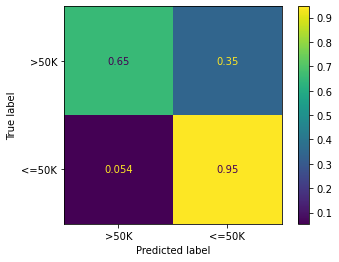

In [4]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

model = HistGradientBoostingClassifier(
        categorical_features=preprocessed_X_train.columns.isin(categorical_cols),
        max_leaf_nodes=30,
        random_state=42
    )
model.fit(preprocessed_X_train, y_train)

y_pred = model.predict(preprocessed_X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[">50K", "<=50K"], normalize="true")

print(classification_report(y_test, y_pred, labels=[">50K", "<=50K"]))

## Cross validation

The train-test-validation split is by far the simplest method to create independent datasets, but it has a major downside: it strongly depends on the way we make this split. After all, the split we do is just one realization of all the possible random splits we could do. This impacts even more if the amount of data is small.

A powerful technique to overcome this problem is **cross validation**. Instead of splitting just once, we repeat the split several times, training the model on the training set and computing scores on the other. At the end, the results of each iteration. This is also a more statistically robust way to assess the generalization performance of a model, as we can also measure its variability across different splits.

There are several cross-validation strategies, but the most used one is **K-fold cross validation**.
1. Split the dataset in $K$ parts (usually 5 or 10),
2. For each one subset $k$:
    1. Train the model on the other $K-1$ parts,
    2. Evaluate on the model on subset $k$.
3. Collect the $K$ results.


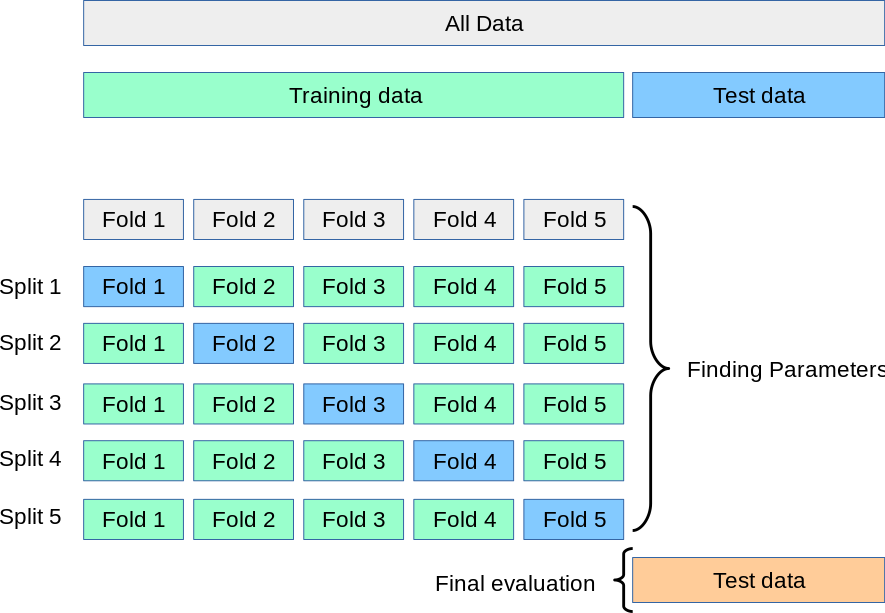


In `scikit-learn` we could use the function [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) to make all the dirty job for us.

In [5]:
from sklearn.model_selection import cross_validate

max_leaf_nodes = [3, 30, 60]

cv_scores = []
for x in max_leaf_nodes:
    model = HistGradientBoostingClassifier(
        categorical_features=preprocessed_X_train.columns.isin(categorical_cols),  # native support for categorical
        max_leaf_nodes=x,
        random_state=42
    )
    cv_scores.append(
        cross_validate(estimator=model, X=preprocessed_X_train, y=y_train, cv=5, scoring="accuracy", verbose=3))

val_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.861 total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ......................................., score=0.863 total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ......................................., score=0.865 total time=   0.5s
[CV] END ......................................., score=0.853 total time=   0.3s
[CV] END ......................................., score=0.856 total time=   0.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.872 total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ......................................., score=0.871 total time=   0.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END ......................................., score=0.872 total time=   0.9s
[CV] END ......................................., score=0.864 total time=   0.8s
[CV] END ......................................., score=0.870 total time=   0.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.870 total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ......................................., score=0.868 total time=   1.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END ......................................., score=0.872 total time=   0.9s
[CV] END ......................................., score=0.863 total time=   0.7s
[CV] END ......................................., score=0.872 total time=   0.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


[0.8581456566247441, 0.8689675343667739, 0.8704299502778591]

## Grid search

So far, our hyperparameter tuning has been somewhat manual: we arbitrarily chose some parameters and train/evaluate a model one by one with a `for` loop over all of them.

This approach is called **grid search** and can be done in an easiest way with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). We can appreciate it tuning multiple parameters at the same time, as we don't need to manually create all combinations. In practice, we just need to specify the model and the parameters we want to check and `GridSearchCV` will do the rest.

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {  # parameters you want to change
    "learning_rate": [0.01, 0.1, 1],
    "max_leaf_nodes": [3, 30, 60]
}
model = HistGradientBoostingClassifier(  # parameters you don't want to change
    categorical_features=preprocessed_X_train.columns.isin(categorical_cols),
    random_state=42
)
grid_search_cv = GridSearchCV(model, param_grid=param_grid, cv=5, refit=True, return_train_score=True, verbose=3)
grid_search_cv.fit(preprocessed_X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.01, max_leaf_nodes=3;, score=(train=0.790, test=0.792) total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_leaf_nodes=3;, score=(train=0.790, test=0.791) total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_leaf_nodes=3;, score=(train=0.790, test=0.792) total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_leaf_nodes=3;, score=(train=0.790, test=0.789) total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_leaf_nodes=3;, score=(train=0.794, test=0.788) total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_leaf_nodes=30;, score=(train=0.854, test=0.851) total time=   0.7s
[CV 2/5] END learning_rate=0.01, max_leaf_nodes=30;, score=(train=0.854, test=0.857) total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_leaf_nodes=30;, score=(train=0.854, test=0.856) total time=   0.7s
[CV 4/5] END learning_rate=0.01, max_leaf_nodes=30;, score=(train=0.857, test=0.849) total time=   0.7s
[CV 5/5] 

GridSearchCV(cv=5,
             estimator=HistGradientBoostingClassifier(categorical_features=array([False, False, False, False, False,  True,  True,  True,  True,
        True]),
                                                      random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_leaf_nodes': [3, 30, 60]},
             return_train_score=True, verbose=3)

In [7]:
grid_search_results = pd.DataFrame(grid_search_cv.cv_results_).drop(columns=["params"])
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.282843,0.006379,0.031146,0.000456,0.01,3,0.791606,0.791459,0.792044,0.788681,...,0.790283,0.001781,9,0.789697,0.789733,0.789551,0.790428,0.793580,0.790598,0.001522
1,0.665018,0.032622,0.044128,0.001003,0.01,30,0.850687,0.856683,0.856391,0.848932,...,0.851707,0.004240,7,0.853570,0.853863,0.853753,0.856970,0.856427,0.854917,0.001468
2,1.029424,0.023212,0.049187,0.000957,0.01,60,0.852004,0.857268,0.859608,0.850687,...,0.853842,0.003898,6,0.857373,0.856861,0.856239,0.861504,0.861911,0.858778,0.002423
3,0.284761,0.018680,0.029855,0.002560,0.1,3,0.861363,0.862825,0.864727,0.852881,...,0.859516,0.004460,4,0.860042,0.860334,0.859420,0.862199,0.861107,0.860620,0.000958
4,0.648432,0.149293,0.042076,0.002692,0.1,30,0.872039,0.870722,0.872477,0.864288,...,0.869929,0.002947,1,0.880626,0.883076,0.882052,0.884282,0.881691,0.882345,0.001245
5,0.884730,0.110262,0.052478,0.007970,0.1,60,0.869991,0.867505,0.872477,0.863410,...,0.869022,0.003286,2,0.889072,0.889108,0.888816,0.886768,0.889661,0.888685,0.000997
6,0.207024,0.058373,0.025514,0.004548,1,3,0.870576,0.869845,0.870722,0.864580,...,0.865278,0.007650,3,0.871668,0.873350,0.870645,0.875434,0.856720,0.869563,0.006624
7,0.120258,0.009836,0.017822,0.000401,1,30,0.864142,0.857999,0.861217,0.852588,...,0.858580,0.003918,5,0.877628,0.873606,0.871083,0.873460,0.881252,0.875406,0.003601
8,0.153597,0.007413,0.019069,0.001731,1,60,0.857561,0.855221,0.852442,0.837379,...,0.851093,0.007098,8,0.882673,0.883076,0.880187,0.874959,0.885018,0.881183,0.003471


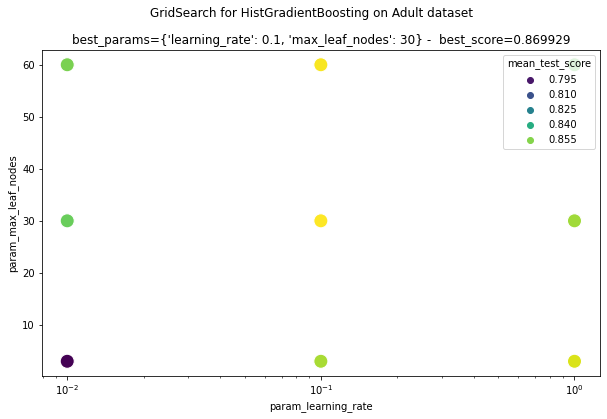

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(
    data=grid_search_results,
    x="param_learning_rate",
    y="param_max_leaf_nodes",
    hue="mean_test_score",
    palette="viridis",
    s=200)
ax.set_xscale("log")
plt.suptitle("GridSearch for HistGradientBoosting on Adult dataset")
plt.title(f"best_params={grid_search_cv.best_params_} -  best_score={grid_search_cv.best_score_:.6f}")
plt.show()

## Randomized search

There are two issues with grid search that we want to address now:
1. The time needed for a grid search scale with the number of combinations of hyperparameters, which can quickly become unfeasible.
2. The regularity of the grid lower our chances to find good regions in parameter space.

The second point is the most important one. Looking at the previous example, the model could have better performance if `learning_rate` lies between `0.01` and `0.1`, but we will never know unless we explicitly make a finer grid.

Surprisingly enough, it turns out that searching the space completely at random is a more efficient way to find good regions of hyperparameters. In practice, after definining the intervals of the parameters we want to search, this procedure picks random combinations for a given number of iterations. The whole space is now sampled more efficiently and our chances to miss interesting regions are lower, especially if hyperamenters are not equally important.

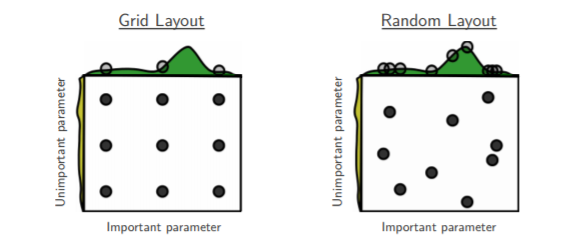

In `scikit-learn` we can use the class [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) to implement a randomized search for hyperparameter tuning.

In [9]:
from scipy.stats import loguniform, randint
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "max_leaf_nodes": randint(3, 60),     # uniform distribution of integers between 3 and 100
    "learning_rate": loguniform(0.01, 1),  # searching across different orders of magnitude is better in log space
}
model = HistGradientBoostingClassifier(
    categorical_features=preprocessed_X_train.columns.isin(categorical_cols),
    random_state=42
)
random_search_cv = RandomizedSearchCV(
    model, param_distributions=param_distributions,
    n_iter=40, random_state=42, verbose=2
)
random_search_cv.fit(preprocessed_X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END learning_rate=0.05611516415334504, max_leaf_nodes=31; total time=   0.7s
[CV] END learning_rate=0.05611516415334504, max_leaf_nodes=31; total time=   1.0s
[CV] END learning_rate=0.05611516415334504, max_leaf_nodes=31; total time=   0.7s
[CV] END learning_rate=0.05611516415334504, max_leaf_nodes=31; total time=   0.7s
[CV] END learning_rate=0.05611516415334504, max_leaf_nodes=31; total time=   0.7s
[CV] END learning_rate=0.02327392228062871, max_leaf_nodes=10; total time=   0.4s
[CV] END learning_rate=0.02327392228062871, max_leaf_nodes=10; total time=   0.4s
[CV] END learning_rate=0.02327392228062871, max_leaf_nodes=10; total time=   0.4s
[CV] END learning_rate=0.02327392228062871, max_leaf_nodes=10; total time=   0.4s
[CV] END learning_rate=0.02327392228062871, max_leaf_nodes=10; total time=   0.4s
[CV] END learning_rate=0.15751320499779722, max_leaf_nodes=41; total time=   0.4s
[CV] END learning_rate=0.15751320499

[CV] END learning_rate=0.013492834268013246, max_leaf_nodes=6; total time=   0.3s
[CV] END .learning_rate=0.766308268025585, max_leaf_nodes=16; total time=   0.1s
[CV] END .learning_rate=0.766308268025585, max_leaf_nodes=16; total time=   0.1s
[CV] END .learning_rate=0.766308268025585, max_leaf_nodes=16; total time=   0.1s
[CV] END .learning_rate=0.766308268025585, max_leaf_nodes=16; total time=   0.1s
[CV] END .learning_rate=0.766308268025585, max_leaf_nodes=16; total time=   0.1s
[CV] END learning_rate=0.41380401125610133, max_leaf_nodes=11; total time=   0.2s
[CV] END learning_rate=0.41380401125610133, max_leaf_nodes=11; total time=   0.2s
[CV] END learning_rate=0.41380401125610133, max_leaf_nodes=11; total time=   0.2s
[CV] END learning_rate=0.41380401125610133, max_leaf_nodes=11; total time=   0.2s
[CV] END learning_rate=0.41380401125610133, max_leaf_nodes=11; total time=   0.2s
[CV] END learning_rate=0.01076297928574797, max_leaf_nodes=4; total time=   0.3s
[CV] END learning_rate

RandomizedSearchCV(estimator=HistGradientBoostingClassifier(categorical_features=array([False, False, False, False, False,  True,  True,  True,  True,
        True]),
                                                            random_state=42),
                   n_iter=40,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0a0cb6dc90>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0a0ced9710>},
                   random_state=42, verbose=2)

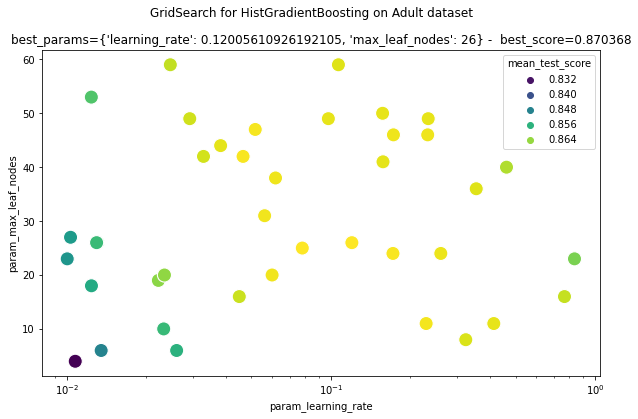

In [10]:
random_search_results = pd.DataFrame(random_search_cv.cv_results_).drop(columns=["params"])

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(
    data=random_search_results,
    x="param_learning_rate",
    y="param_max_leaf_nodes",
    hue="mean_test_score",
    palette="viridis",
    s=200)
ax.set_xscale("log")
plt.suptitle("GridSearch for HistGradientBoosting on Adult dataset")
plt.title(f"best_params={random_search_cv.best_params_} -  best_score={random_search_cv.best_score_:.6f}")
plt.show()

## Conclusions

In this notebook we have learned how to do a hyperparameter search, understanding the difference between a grid and a randomized search. We could also appreciate the limitations of simple train-test-validation splitting and use cross validation as a more statistically robust procedure to assess the performance of a model.